# Introduction
Covid-19 spread swiftly around the world. New York city is one of the hot zones. Assume people in New York city will stay home. Some of them will not cook a lot, they would like to ask food delivery.If we want to do uber delivery. we need to know which neighborhood has most of the Fast Food Restaurants. Then using foursquare to check comments on each "Fast Food Restaurant" to find out most popular restaurants in the neighborhood. So we can work around those restaurants to reduce any waiting time and to get maximium profit.

Data
To do this we need using following data Data source: https://cocl.us/new_york_dataset and foursquare.com. In new_york_dataset data source, it includes Boroughs, Neighborhoods with their latitude and longitude. Using fousquare to get the latitude and longitude values of New York City, then filter the values with only fast food restaurants, and looking for rates for each fast food restaurants to find out high rate fast food restaurants in each neighborhoods. Lastly, python packages will be used to create maps and machine leanirng models to help make decision.

Methodology

collect the new york city data from https://cocl.us/new_york_dataset
Using FourSquare API to find all venues for each neighborhood.
Filter out all venues that are fast food restaurants and checking the rating
Using Python visualization library to visualize the neighborhoods cluster and machine learning algorithm K-Mean custering to find the result.

The requried libraires will be used.

In [1]:

!pip install geopy
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
 
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

import matplotlib.pyplot as plt

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-1.1.1g             |       h516909a_1         2.1 MB  conda-forge
    branca-0.4.1               |             py_0          26 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    certifi-2020.6.20          |   py36h9f0ad1d_0         151 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    altair-4.1.0               |             py_1         614 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    ------------------------------------------------------------
                       

In [ ]:
Retrieve data and only bring data such as 'Borough', 'Neighborhood', 'Latitude', 'Longitude'
 

In [2]:
def new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data


In [ ]:
Get New York data  

In [3]:
NY =  new_york_data()
NY.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [ ]:
Total boroughs and Neighborhood in new york city 

In [4]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(NY['Borough'].unique()),
        NY.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


In [ ]:
Use geopy library to get the latitude and longitude values of New York City.
In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent ny_explorer, as shown below.
 

In [5]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [ ]:
Get all the venue from foursquare via API 

In [6]:

def getNearbyVenues(lat,lng):
    
     
    CLIENT_ID = 'BIP4TGESRK4WPJ1CBOUWYCHJLKE0GOQQSZWM5SWKVE5ZBWHF' # your Foursquare ID
    CLIENT_SECRET = 'GOYOACQFMOS2LFBZHIJMGOR1BEH1R0HJPFOXE0AVERZKD212' # your Foursquare Secret
    VERSION = '20180605' # Foursquare API version

    LIMIT = 100 # limit of number of venues returned by Foursquare API
    radius = 500 # define radius
    
     #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [ ]:
Inintally try to find all the fast food or take away category, but can not find any, then using Restaurant, and assume all the restaurants are doing take away now 

In [7]:
import re
print ('start')
column_names=['Borough', 'Neighborhood', 'ID','Name']
restaurant_ny=pd.DataFrame(columns=column_names)
count=1
for row in NY.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = getNearbyVenues(Latitude,Longitude)
    restaurant=venues[venues["Category"] =='Restaurant']  #Restaurant, fast food, take away 
    for resturant_detail in restaurant.values.tolist():
        id, name , category=resturant_detail
        restaurant_ny = restaurant_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1    

start


In [ ]:
List all the restaurants in NY city 

In [8]:
restaurant_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Co-op City,4be2b79d660ec9284d04ca3b,Townhouse Restaurant
1,Bronx,Co-op City,4c7001dfdf6b8cfa56c9b64d,Seven Seas
2,Bronx,Norwood,4c816d75e602b1f78acb927a,V.I.P.'S Cafe
3,Bronx,East Tremont,4b643ec5f964a5202ca62ae3,El Valle Restaurant
4,Bronx,Port Morris,4ddaa9ccd1647fcf3e96c5c8,Walnut Bus Stop


In [9]:
restaurant_ny.shape

(82, 4)

In [ ]:
figure out how many restaurants in each Borough

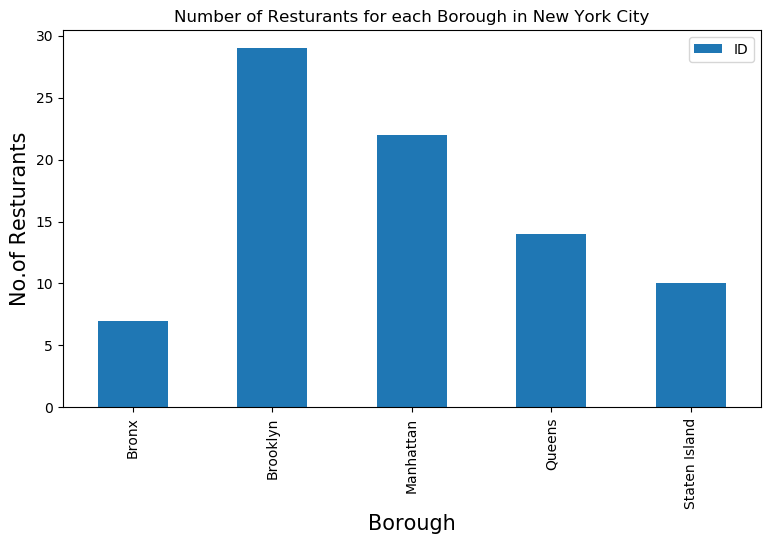

In [10]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Resturants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Resturants', fontsize=15)
#giving a bar plot
restaurant_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [ ]:
then check How many Neighborhoods in each Borough

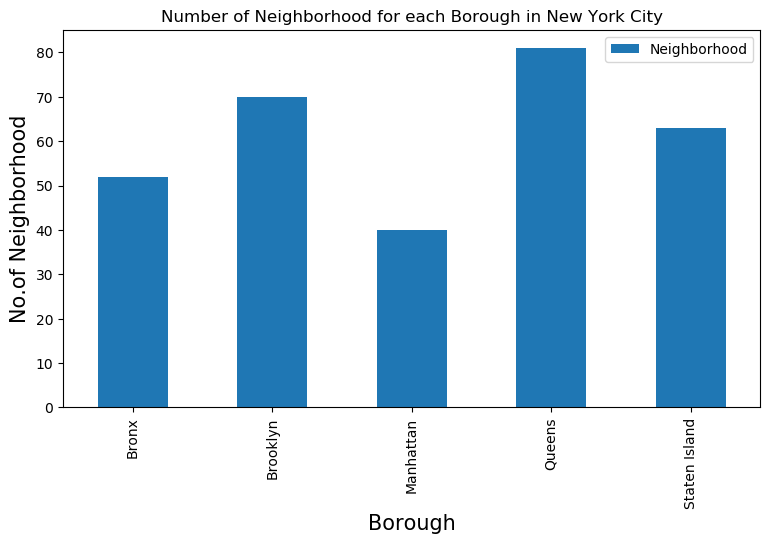

In [12]:

plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
NY.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [ ]:
Based on listed restaurants to find all the rates and tips 

In [11]:
def get_venue_details(venue_id):
        
    CLIENT_ID = 'BIP4TGESRK4WPJ1CBOUWYCHJLKE0GOQQSZWM5SXXXX' # i have changed the id with ##
    CLIENT_SECRET = 'GOYOACQFMOS2LFBZHIJMGOR1BEH1R0HJPFOXE0AVERXXX' # i have changed the secret with ##
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()    
    venue_data=results["response"]['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df 

In [13]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
restaurant_rating_ny=pd.DataFrame(columns=column_names)
count=1

print ('start')
for row in restaurant_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        id,name,likes,rating,tips=[0]*5  
    restaurant_rating_ny = restaurant_rating_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

start
                         ID                  Name  Likes  Rating  Tips
0  4be2b79d660ec9284d04ca3b  Townhouse Restaurant      3     5.7     5
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
                         ID           Name  Likes  Rating  Tips
0  4c816d75e602b1f78acb927a  V.I.P.'S Cafe      6     6.9     1
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
                         ID                              Name  Likes  Rating  \
0  529ea69511d2cbb2c4d6e9de  Evo cocktail lounge & restaurant     13     6.5   

   Tips  
0     5  
                         ID                        Name  Likes  Rating  Tips
0  55d7c6bb498efa168c9483a9  Archestratus Books & Foods     91     9.4    12
                         ID   Name  Likes  Rating  Tips
0  5cfda20a0d8a0f002cba15f3  Madre     16     8.1     9
         

KeyError: 'venue'

In [ ]:
Merge restaurant rate result with NY Latitude and Longitude data   

In [135]:
restaurant_rating_ny = pd.merge (restaurant_rating_ny, NY, on='use_id')
restaurant_rating_ny.head() 

,Borough_x,Neighborhood,ID,Name,Likes,Rating,Tips,Borough_y,Latitude_x,Longitude_x,Borough,Latitude_y,Longitude_y
0,Bronx,Co-op City,4be2b79d660ec9284d04ca3b,Townhouse Restaurant,3.0,5.7,5.0,Bronx,40.874294,-73.829939,Bronx,40.874294,-73.829939
1,Bronx,Co-op City,0,0,0.0,0.0,0.0,Bronx,40.874294,-73.829939,Bronx,40.874294,-73.829939
2,Bronx,Norwood,4c816d75e602b1f78acb927a,V.I.P.'S Cafe,6.0,6.9,1.0,Bronx,40.877224,-73.879391,Bronx,40.877224,-73.879391
3,Bronx,East Tremont,0,0,0.0,0.0,0.0,Bronx,40.842696,-73.887356,Bronx,40.842696,-73.887356
4,Bronx,Port Morris,0,0,0.0,0.0,0.0,Bronx,40.801664,-73.913221,Bronx,40.801664,-73.913221


In [136]:
restaurant_rating_ny.shape

(53, 13)

In [104]:
restaurant_rating_ny.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53 entries, 0 to 52
Data columns (total 13 columns):
Borough_x       53 non-null object
Neighborhood    53 non-null object
ID              53 non-null object
Name            53 non-null object
Likes           53 non-null float64
Rating          53 non-null float64
Tips            53 non-null float64
Borough_y       53 non-null object
Latitude_x      53 non-null float64
Longitude_x     53 non-null float64
Borough         53 non-null object
Latitude_y      53 non-null float64
Longitude_y     53 non-null float64
dtypes: float64(7), object(6)
memory usage: 5.8+ KB


In [ ]:
change columns format       

In [105]:
restaurant_rating_ny['Likes']= restaurant_rating_ny['Likes'].astype('float64')

In [106]:
restaurant_rating_ny['Tips']= restaurant_rating_ny['Tips'].astype('float64')

In [107]:
restaurant_rating_ny.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53 entries, 0 to 52
Data columns (total 13 columns):
Borough_x       53 non-null object
Neighborhood    53 non-null object
ID              53 non-null object
Name            53 non-null object
Likes           53 non-null float64
Rating          53 non-null float64
Tips            53 non-null float64
Borough_y       53 non-null object
Latitude_x      53 non-null float64
Longitude_x     53 non-null float64
Borough         53 non-null object
Latitude_y      53 non-null float64
Longitude_y     53 non-null float64
dtypes: float64(7), object(6)
memory usage: 5.8+ KB


In [ ]:
get the highest Like restaurant details 

In [108]:
restaurant_rating_ny.iloc[restaurant_rating_ny['Likes'].idxmax()]

Borough_x                      Manhattan
Neighborhood          Financial District
ID              5c883f65f4b525002c0bf2ca
Name                           Crown Shy
Likes                                155
Rating                               9.4
Tips                                  32
Borough_y                      Manhattan
Latitude_x                       40.7071
Longitude_x                     -74.0107
Borough                        Manhattan
Latitude_y                       40.7071
Longitude_y                     -74.0107
Name: 52, dtype: object

In [ ]:
get the highest Rate restaurant details 

In [109]:
restaurant_rating_ny.iloc[restaurant_rating_ny['Rating'].idxmax()]

Borough_x                         Brooklyn
Neighborhood                    Greenpoint
ID                55d7c6bb498efa168c9483a9
Name            Archestratus Books & Foods
Likes                                   91
Rating                                 9.4
Tips                                    12
Borough_y                         Brooklyn
Latitude_x                         40.7302
Longitude_x                       -73.9542
Borough                           Brooklyn
Latitude_y                         40.7302
Longitude_y                       -73.9542
Name: 7, dtype: object

In [ ]:
get the highest Tips restaurant details

In [110]:
restaurant_rating_ny.iloc[restaurant_rating_ny['Tips'].idxmax()]

Borough_x                       Brooklyn
Neighborhood             Gerritsen Beach
ID              4a4e253df964a52027ae1fe3
Name                         TGI Fridays
Likes                                 69
Rating                               6.2
Tips                                  43
Borough_y                       Brooklyn
Latitude_x                       40.5908
Longitude_x                     -73.9301
Borough                         Brooklyn
Latitude_y                       40.5908
Longitude_y                     -73.9301
Name: 26, dtype: object

In [111]:
ny_Borough_stats=restaurant_rating_ny.groupby(['Borough'],as_index=False).mean()[['Borough','Rating']]
ny_Borough_stats.columns=['Borough','Average Rating']

In [ ]:
check average rating for each Borough

In [112]:
ny_Borough_stats.sort_values(by=['Average Rating'], ascending=False)

,Borough,Average Rating
3,Staten Island,8.700000
2,Manhattan,7.156250
1,Brooklyn,6.714286
0,Bronx,2.728571


In [138]:
ny_neighborhood_stats=restaurant_rating_ny.groupby(['Borough', 'Neighborhood', 'Name'],as_index=False).mean()[['Borough','Neighborhood', 'Name','Rating']]
ny_neighborhood_stats.columns=['Borough','Neighborhood','Name', 'Average Rating']

In [ ]:
list restaurants with their Borough and Neighborhood in descending order 

In [139]:
ny_neighborhood_stats.sort_values(by=['Average Rating'], ascending=False)

,Borough,Neighborhood,Name,Average Rating
25,Brooklyn,Greenpoint,Archestratus Books & Foods,9.4
40,Manhattan,Financial District,Crown Shy,9.4
30,Brooklyn,Prospect Heights,Oxalis,9.1
46,Manhattan,Lenox Hill,Mission Ceviche,8.8
16,Brooklyn,Clinton Hill,Bar Bolinas,8.7
48,Manhattan,Washington Heights,The Uptown Garrison,8.7
36,Manhattan,Chelsea,The Orchard Townhouse,8.7
19,Brooklyn,Cobble Hill,Hadramout Restaurant,8.7
50,Staten Island,Chelsea,The Orchard Townhouse,8.7
41,Manhattan,Gramercy,Studio,8.6


In [ ]:
list Average rating for each Borough in bar 

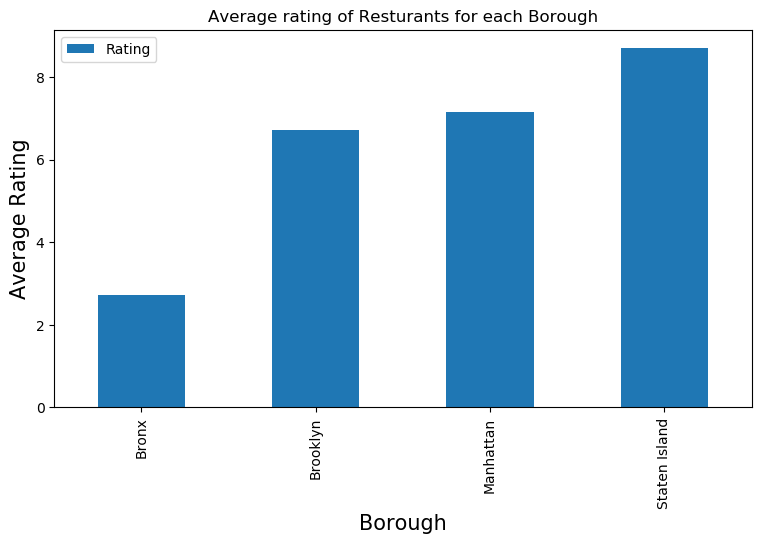

In [142]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Resturants for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
restaurant_rating_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [120]:
ny_neighborhood_stats = pd.merge (ny_neighborhood_stats, NY,on='Neighborhood')
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

In [121]:
!pip install geopy
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)

In [144]:
ny_neighborhood_stats = pd.merge (ny_neighborhood_stats, NY,on='Neighborhood')

ny_neighborhood_stats.head()

,Borough_x,Neighborhood,Name,Average Rating,Borough_y,Latitude,Longitude
0,Bronx,Co-op City,0,0.0,Bronx,40.874294,-73.829939
1,Bronx,Co-op City,Townhouse Restaurant,5.7,Bronx,40.874294,-73.829939
2,Bronx,East Tremont,0,0.0,Bronx,40.842696,-73.887356
3,Bronx,Hunts Point,0,0.0,Bronx,40.809730,-73.883315
4,Bronx,Norwood,V.I.P.'S Cafe,6.9,Bronx,40.877224,-73.879391


In [145]:
ny_neighborhood_stats=ny_neighborhood_stats[['Borough_x','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats.rename(columns = {'Borough_x':'Borough' }, inplace = True)
ny_neighborhood_stats.head()

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Bronx,Co-op City,40.874294,-73.829939,0.0
1,Bronx,Co-op City,40.874294,-73.829939,5.7
2,Bronx,East Tremont,40.842696,-73.887356,0.0
3,Bronx,Hunts Point,40.809730,-73.883315,0.0
4,Bronx,Norwood,40.877224,-73.879391,6.9


In [131]:
ny_neighborhood_stats.head()

,Borough,Neighborhood,Latitude,Longitude,Average Rating,Label
0,Bronx,Co-op City,40.874294,-73.829939,2.85,"Co-op City, Bronx(2.85)"
1,Bronx,East Tremont,40.842696,-73.887356,0.00,"East Tremont, Bronx(0.0)"
2,Bronx,Hunts Point,40.809730,-73.883315,0.00,"Hunts Point, Bronx(0.0)"
3,Bronx,Norwood,40.877224,-73.879391,6.90,"Norwood, Bronx(6.9)"
4,Bronx,Parkchester,40.837938,-73.856003,6.50,"Parkchester, Bronx(6.5)"


In [ ]:
Now list all the data on the map 

In [132]:
restaurant = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    restaurant.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )


In [133]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'


In [134]:
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(restaurant)

# Conclusion 
looks like most higher rate restaurants are in Brooklyn and Manhattan Borough. (Although Staten Island has the highest average rate restaurant, but it is the only one in the Borough)  	  
Top 3 restaurants are: 
    Archestratus Books & Foods (Brooklyn; Greenpoint) 
    Crown Shy (Manhattan; Financial District) 	
    Oxalis (Brooklyn ;Prospect Heights)  
Therefore, if want to do Uber deliver, those two Boroughs (Brooklyn and Manhattan) are the best places. Also, What I find is some neighborhoods in both boroughs have more than one restaurants has good rates. The neighborhoods such as 
    Clinton Hill, Cobble Hill, Greenpoint in Brooklyn 
    Inwood, clinton in Manhattan.

Limitations

